# XGBoost

In this notebook, we train XGBoost models to predict dry (0) or wet (1) for a given HJ Andrews HOBO Sensor Site 3 days after a given date. The model uses features at time t and the current wet/dry status (target[t]) to predict target[t+3]. We apply ADASYN to the training data.

We experiment with the following train-test-splitting strategies:
- Random
- Temporal
- Site-based

At the bottom of the notebook, we provide a function for practictioners to run inference with our trained models for an inputted site-date combination.

## Imports

In [6]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(42)

## Data Preprocessing

In [7]:
# Data Paths
DRIVERS_PATH = "/Users/michaelmurphy/Desktop/usgs_data/drivers_xgb.csv"
OBS_PATH = "/Users/michaelmurphy/Desktop/usgs_data/obs.parquet"
STATIC_PATH = "/Users/michaelmurphy/Desktop/usgs_data/static_vars.parquet"
DEGREES_PATH = "/Users/michaelmurphy/Desktop/usgs_data/degrees.parquet"

# Load drivers dataset as CSV
drivers = pd.read_csv(DRIVERS_PATH)

# Loads obs data
data = pd.read_parquet(OBS_PATH)

# Load in remaining datasets
static_df = pd.read_parquet(STATIC_PATH)
degrees = pd.read_parquet(DEGREES_PATH)

data

,NHDPlusID,SiteIDCode,Date,variable,value
0,55000900130309,GSWS01,1980-01-01,Discharge_CMS,0.045505
1,55000900130309,GSWS01,1980-01-02,Discharge_CMS,0.043410
2,55000900130309,GSWS01,1980-01-03,Discharge_CMS,0.048592
3,55000900130309,GSWS01,1980-01-04,Discharge_CMS,0.061872
4,55000900130309,GSWS01,1980-01-05,Discharge_CMS,0.276599
...,...,...,...,...,...
160731,55000900130309,WDLookMcRaeID1,2020-07-08,MaxDepth_Threshold,0.000000
160732,55000900130309,WDLookMcRaeID1,2020-07-08,MaxDepth_Censor,1.000000
160733,55000900130309,WDLookMcRaeID1,2020-08-12,MaxDepth_cm,51.816000
160734,55000900130309,WDLookMcRaeID1,2020-08-12,MaxDepth_Threshold,0.000000


In [8]:
# Isolate the target variable by creating dictionary of all metrics and choosing 'value'
dfs = {val: data[data['variable'] == val ]for val in data['variable'].unique()}

wet_dry_df = dfs['HoboWetDry0.05']

In [9]:
# Make sure all NHD IDs are strings, normalize before merging
wet_dry_df['NHDPlusID'] = wet_dry_df['NHDPlusID'].astype(str)
drivers['NHDPlusID'] = drivers['NHDPlusID'].astype(str)
static_df['NHDPlusID'] = static_df['NHDPlusID'].astype(str)

# Make sure all date values are in datetime format, normalize before merging
wet_dry_df['Date'] = pd.to_datetime(wet_dry_df['Date'])
drivers['Date'] = pd.to_datetime(drivers['Date'])

static_df_pivot = static_df.pivot(
    index='NHDPlusID',
    columns='variable',
    values='value'
).reset_index()

# Merge all datasets to create one central dataset
central_df = wet_dry_df.merge(drivers, on=['NHDPlusID', 'Date'], how='inner')
central_df = central_df.merge(static_df_pivot, on='NHDPlusID', how='left')
central_df = central_df.merge(degrees, on='NHDPlusID', how='left')

/var/folders/jd/4sjpm6q97knfqgwsf50gr3jh0000gn/T/ipykernel_51559/2394861375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wet_dry_df['NHDPlusID'] = wet_dry_df['NHDPlusID'].astype(str)
/var/folders/jd/4sjpm6q97knfqgwsf50gr3jh0000gn/T/ipykernel_51559/2394861375.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wet_dry_df['Date'] = pd.to_datetime(wet_dry_df['Date'])


In [10]:
# Sort by date within each NHDPlusID
central_df = central_df.sort_values(['NHDPlusID', 'Date'])

# Target: wet/dry status 3 days ahead (target[t+3])
central_df['wet_dry_next'] = central_df.groupby('NHDPlusID')['value'].shift(-3)

# Drop rows with NaN values from lag and target
central_df = central_df.dropna(subset=['wet_dry_next'])

In [11]:
central_df

,NHDPlusID,SiteIDCode,Date,variable,value,etalfalfa,etgrass,prcp,rhmax,rhmin,...,curv_median,elev_max_cm,elev_mean_cm,elev_median_cm,elev_min_cm,slp_mean_pct,slp_median_pct,In-degree,Out-degree,wet_dry_next
5,55000900029021,HoboSite89,2020-06-18,HoboWetDry0.05,1.0,7.000000,5.600000,0.000000,100.000000,34.200001,...,30.785751,111282.0,99949.028293,99436.0,88848.0,33.361886,30.785751,2,1,1.0
1951,55000900029021,HoboSite89,2020-06-19,HoboWetDry0.05,1.0,7.000000,5.700000,0.000000,87.099998,32.000000,...,30.785751,111282.0,99949.028293,99436.0,88848.0,33.361886,30.785751,2,1,1.0
1952,55000900029021,HoboSite89,2020-06-20,HoboWetDry0.05,1.0,4.700000,4.000000,1.400000,90.400002,62.600002,...,30.785751,111282.0,99949.028293,99436.0,88848.0,33.361886,30.785751,2,1,1.0
1953,55000900029021,HoboSite89,2020-06-21,HoboWetDry0.05,1.0,5.200000,4.600000,0.000000,98.400002,48.600002,...,30.785751,111282.0,99949.028293,99436.0,88848.0,33.361886,30.785751,2,1,1.0
1954,55000900029021,HoboSite89,2020-06-22,HoboWetDry0.05,1.0,8.500000,6.500000,0.000000,100.000000,29.300001,...,30.785751,111282.0,99949.028293,99436.0,88848.0,33.361886,30.785751,2,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1580,55000900272714,HoboSite115,2020-10-14,HoboWetDry0.05,1.0,1.268010,1.168010,0.000000,100.000000,65.824175,...,46.400970,148817.0,113542.048173,114088.0,91145.0,46.146702,46.400970,2,1,1.0
1581,55000900272714,HoboSite115,2020-10-15,HoboWetDry0.05,1.0,3.927961,2.595971,1.668010,89.840048,30.520389,...,46.400970,148817.0,113542.048173,114088.0,91145.0,46.146702,46.400970,2,1,1.0
1582,55000900272714,HoboSite115,2020-10-16,HoboWetDry0.05,1.0,3.831990,2.631990,0.904029,90.748351,35.292185,...,46.400970,148817.0,113542.048173,114088.0,91145.0,46.146702,46.400970,2,1,1.0
1583,55000900272714,HoboSite115,2020-10-17,HoboWetDry0.05,1.0,1.800000,1.400000,0.000000,99.523934,54.076312,...,46.400970,148817.0,113542.048173,114088.0,91145.0,46.146702,46.400970,2,1,1.0


## Random Split

In [12]:
def random_split(central_df):
    # Features and target
    X = central_df.drop('wet_dry_next', axis=1)
    y = central_df['wet_dry_next']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )

    return X_train, X_test, y_train, y_test

## Temporal Split

In [13]:
def temporal_split(central_df, split_date = '2020-9-15'):
    # Sort by time
    df = central_df.sort_values(['Date'])

    # Introduce temporal splitting
    # Every entry before 9/15 is training; rest is testing
    train = df[df['Date'] < split_date]
    test = df[df['Date'] >= split_date]

    X_train = train.drop('wet_dry_next', axis=1)
    y_train = train['wet_dry_next']
    X_test = test.drop('wet_dry_next', axis=1)
    y_test = test['wet_dry_next']

    return X_train, X_test, y_train, y_test

## Site-Based Split

In [14]:
def site_split(central_df):
    # Sort data chronologically
    central_df = central_df.sort_values(['Date']).reset_index(drop=True)

    # Split sites into train and test groups
    sites = central_df['SiteIDCode'].unique()
    train_sites = sites[:int(0.8 * len(sites))]
    test_sites  = sites[int(0.8 * len(sites)):]

    # Create site-based train and test sets
    train = central_df[central_df['SiteIDCode'].isin(train_sites)].copy()
    test  = central_df[central_df['SiteIDCode'].isin(test_sites)].copy()

    # Features and target
    X_train = train.drop('wet_dry_next', axis=1)
    y_train = train['wet_dry_next']
    X_test = test.drop('wet_dry_next', axis=1)
    y_test = test['wet_dry_next']

    return X_train, X_test, y_train, y_test

## ADASYN Resampling and Model Training

In [15]:
X_train, X_test, y_train, y_test = temporal_split(central_df)

# Drop non-numerical, non-influential columns
X_train = X_train.drop(['variable', 'NHDPlusID', 'SiteIDCode', 'Date'], axis = 1)
X_test = X_test.drop(['variable', 'NHDPlusID', 'SiteIDCode', 'Date'], axis = 1)

In [16]:
# Apply ADASYN to fix class imbalance
adasyn = ADASYN(random_state=42)
X_train, y_train = adasyn.fit_resample(X_train, y_train)

In [17]:
# Define XGBoost model and fit it on training data
XGB_model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

XGB_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

## Metrics and Feature Importance - Temporal Split

In [18]:
# Apply model onto test data and save predictions
y_pred = XGB_model.predict(X_test)

# Obtain performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9615
ROC-AUC: 0.9517
F1 Score: 0.9757


In [19]:
# Print classification report
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.883     0.935     0.909       154
         1.0      0.983     0.968     0.976       600

    accuracy                          0.962       754
   macro avg      0.933     0.952     0.942       754
weighted avg      0.963     0.962     0.962       754



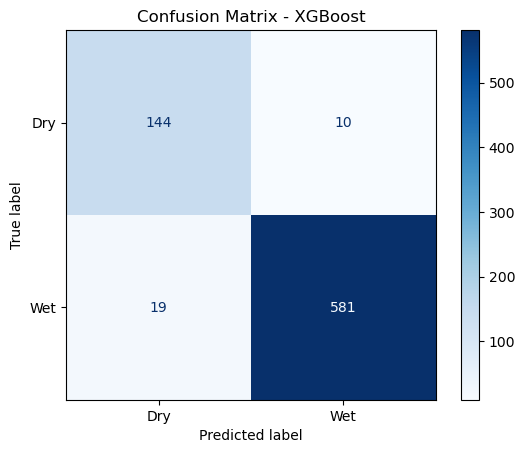

In [20]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dry', 'Wet'])
disp.plot(cmap='Blues', values_format='d')

plt.title("Confusion Matrix - XGBoost")
plt.show()

In [21]:
# Make feature importances table
feature_cols = X_train.columns.tolist()

coefficients = pd.DataFrame({
    "Feature": feature_cols,
    "Coefficient": XGB_model.feature_importances_
})

#Sort by absolute value to see most important features
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

print(coefficients[['Feature', 'Coefficient']].to_string(index=False))


       Feature  Coefficient
         value     0.783108
  elev_mean_cm     0.048746
    Out-degree     0.032812
     etalfalfa     0.021470
   elev_max_cm     0.018194
 aspect_ne_pct     0.009258
 aspect_se_pct     0.008038
       etgrass     0.007680
     curv_mean     0.007354
         rhmin     0.006931
     TotDASqKm     0.006901
            vp     0.006721
         rhmax     0.006189
          tmax     0.004904
      LengthKM     0.004543
           sph     0.004398
          tmin     0.004381
            ws     0.003945
          srad     0.003834
    ArbolateSu     0.003593
      AreaSqKm     0.003293
 aspect_nw_pct     0.002957
   elev_min_cm     0.000751
     In-degree     0.000000
elev_median_cm     0.000000
slp_median_pct     0.000000
  slp_mean_pct     0.000000
          prcp     0.000000
   curv_median     0.000000
 aspect_sw_pct     0.000000
        ToNode     0.000000
      FromNode     0.000000
         Slope     0.000000


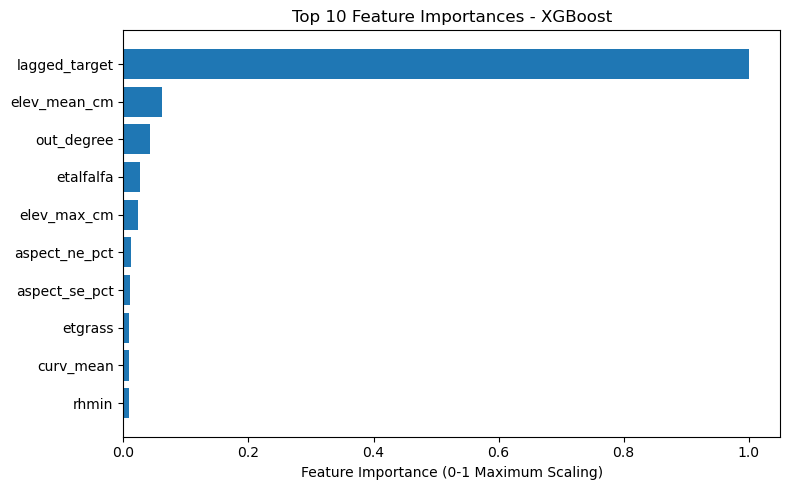

In [22]:
# Rename features for visualization
importance = coefficients[['Feature', 'Abs_Coefficient']].copy()
importance['Feature'] = importance['Feature'].replace({
    'Out-degree': 'out_degree',
    'In-degree': 'in_degree',
    'value': 'lagged_target',
})

# Scale to 0-1 (max-normalization, consistent with LR notebook)
importance['Importance'] = importance['Abs_Coefficient'] / importance['Abs_Coefficient'].max()

# Plot top 10
top10 = importance.head(10)

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(top10['Feature'][::-1], top10['Importance'][::-1])
ax.set_xlabel('Feature Importance (0-1 Maximum Scaling)')
ax.set_title('Top 10 Feature Importances - XGBoost')
plt.tight_layout()
plt.show()

## Comparison Across Split Strategies

In [23]:
# Train and evaluate XGBoost with each split strategy
drop_cols = ['variable', 'NHDPlusID', 'SiteIDCode', 'Date']
splits = {
    'Random': random_split(central_df),
    'Temporal': temporal_split(central_df),
    'Site-Based': site_split(central_df),
}

split_data = {}
results = []

for name, (X_tr, X_te, y_tr, y_te) in splits.items():
    X_tr = X_tr.drop(drop_cols, axis=1)
    X_te = X_te.drop(drop_cols, axis=1)

    # ADASYN
    adasyn = ADASYN(random_state=42)
    X_tr_res, y_tr_res = adasyn.fit_resample(X_tr, y_tr)

    # Train
    model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
    model.fit(X_tr_res, y_tr_res)

    # Predict
    y_pred = model.predict(X_te)

    split_data[name] = (y_te, y_pred)
    results.append({
        'Split': name,
        'Accuracy': accuracy_score(y_te, y_pred),
        'ROC-AUC': roc_auc_score(y_te, y_pred),
        'F1': f1_score(y_te, y_pred),
    })

# Display metrics table
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

     Split  Accuracy  ROC-AUC       F1
    Random  0.978805 0.967364 0.986920
  Temporal  0.961538 0.951699 0.975651
Site-Based  0.863874 0.882366 0.885965


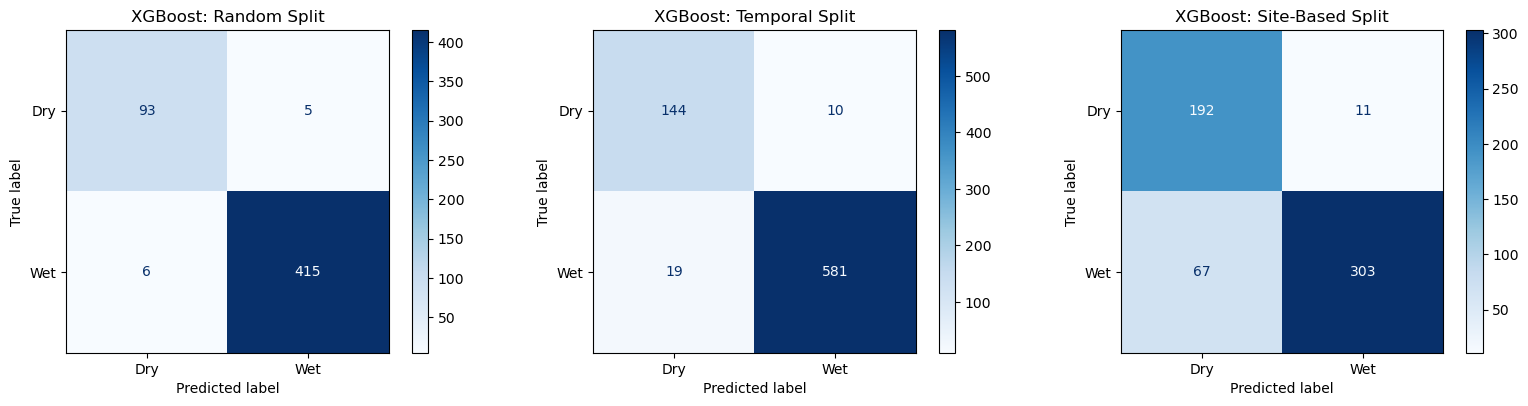


Random Split
              precision    recall  f1-score   support

         Dry      0.939     0.949     0.944        98
         Wet      0.988     0.986     0.987       421

    accuracy                          0.979       519
   macro avg      0.964     0.967     0.966       519
weighted avg      0.979     0.979     0.979       519


Temporal Split
              precision    recall  f1-score   support

         Dry      0.883     0.935     0.909       154
         Wet      0.983     0.968     0.976       600

    accuracy                          0.962       754
   macro avg      0.933     0.952     0.942       754
weighted avg      0.963     0.962     0.962       754


Site-Based Split
              precision    recall  f1-score   support

         Dry      0.741     0.946     0.831       203
         Wet      0.965     0.819     0.886       370

    accuracy                          0.864       573
   macro avg      0.853     0.882     0.859       573
weighted avg      0.886   

In [24]:
# Confusion matrices and classification reports
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, (name, (y_te, y_p)) in zip(axes, split_data.items()):
    cm = confusion_matrix(y_te, y_p, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dry', 'Wet'])
    disp.plot(cmap='Blues', values_format='d', ax=ax)
    ax.set_title(f'XGBoost: {name} Split')

plt.tight_layout()
plt.show()

for name, (y_te, y_p) in split_data.items():
    print(f"\n{'='*50}")
    print(f"{name} Split")
    print('='*50)
    print(classification_report(y_te, y_p, target_names=['Dry', 'Wet'], digits=3))

## Inference

In [25]:
def predict_site_date(model, central_df, site_id, date, days_ahead=3):
  """
  Predict wet/dry status for a given site on day n+days_ahead given its wet/dry status and features on day n.
  
  Parameters:
  -----------
  model : XGBoostClassifier
      Trained XGBoost model
  central_df : pd.DataFrame
      Complete dataset with all features
  site_id : str
      Site identifier (e.g., "HoboSite100")
  date : str
      Date in format "YYYY-MM-DD"
  
  Returns:
  --------
  str : Prediction result with probability
  """
  date = pd.to_datetime(date)
  site_id = str(site_id)

  row = central_df[(central_df["SiteIDCode"] == site_id) & (central_df["Date"] == date)]

  if row.empty:
      return f"No data found for Site {site_id} on {date.date()}"
  
  Xq = row[feature_cols]

  pred_class = model.predict(Xq)
  pred_prob = model.predict_proba(Xq)[:, 1]

  return f"Site {site_id} on {(date + pd.Timedelta(days=days_ahead)).date()} (predicted from {date.date()}): {'DRY' if pred_class == 0 else 'WET'}, (P(wet)={pred_prob[0]:.4f})"

In [26]:
# Example inference
predict_site_date(
    model=XGB_model,
    central_df=central_df,
    site_id="HoboSite100",
    date="2020-10-22"
)

'Site HoboSite100 on 2020-10-25 (predicted from 2020-10-22): DRY, (P(wet)=0.0018)'